In [27]:
import numpy as np

class Data():
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.train_image_count = None
        self.test_image_count = None

        self.loadTrainData()
        self.loadTrainLabel()
        self.loadTestData()
        self.loadTestLabel()

    def loadTrainData(self):
        with open('./data/train-images-idx3-ubyte', 'rb') as inputfile:
            content = inputfile.read()
        self.train_image_count = int.from_bytes(content[4:8], 'big') # 手書き画像枚数
        self.image_row = int.from_bytes(content[8:12], 'big') # 手書き画像行数
        self.image_col = int.from_bytes(content[12:16], 'big') # 手書き画像列数
        images = np.frombuffer(content, np.uint8, -1, 16)# 手書き画像データの読み込み
        self.X_train = images.reshape(self.train_image_count, self.image_row * self.image_col, 1) # 一つの画像を一列にまとめる

    def loadTrainLabel(self):
        with open('./data/train-labels-idx1-ubyte', 'rb') as inputfile:
            content = inputfile.read()
        labels = np.frombuffer(content, np.uint8, -1, 8) #ラベルの読み込み(5,0,4,...)
        #one_hot_vectorに変換
        one_hot_labels =  np.zeros([self.train_image_count, 10])
        for i in range(self.train_image_count):
            one_hot_labels[i, labels[i]] = 1
        self.y_train = one_hot_labels.reshape(self.train_image_count,10,1)
    
    def loadTestData(self):
        with open('./data/t10k-images-idx3-ubyte', 'rb') as inputfile:
            content = inputfile.read()
        self.test_image_count = int.from_bytes(content[4:8], 'big') # 手書き画像枚数
        images = np.frombuffer(content, np.uint8, -1, 16)# 手書き画像データの読み込み
        self.X_test = images.reshape(self.test_image_count, self.image_row * self.image_col, 1) # 一つの画像を一列にまとめる
        
    def loadTestLabel(self):
        with open('./data/t10k-labels-idx1-ubyte', 'rb') as inputfile:
            content = inputfile.read()
        labels = np.frombuffer(content, np.uint8, -1, 8) #ラベルの読み込み(5,0,4,...)
        #one_hot_vectorに変換
        one_hot_labels =  np.zeros([self.test_image_count, 10])
        for i in range(self.test_image_count):
            one_hot_labels[i, labels[i]] = 1
        self.y_test = one_hot_labels.reshape(self.test_image_count,10,1)

In [28]:
data = Data()

In [100]:
import random 
import matplotlib.pyplot as plt
%matplotlib inline


class NeuralNetworkModel():

    def __init__(self, hidden_dim):
        self.input_dim = 784
        self.hidden_dim = hidden_dim
        self.output_dim = 10
        self.w_ih = np.random.randn(self.hidden_dim, self.input_dim) /np.sqrt(self.input_dim) * 0.01
        self.b_ih = np.random.randn(self.hidden_dim, 1)
        self.w_ho =np.random.randn(self.output_dim, self.hidden_dim) /np.sqrt(self.input_dim) * 0.01
        self.b_ho = np.random.randn(self.output_dim, 1)

    def SGD(self, x_train, y_train, epochs, mini_batch_size, eta, lmbda, x_test=None, y_test=None):
        x = np.arange(0, epochs)
        accuracies = np.zeros(epochs)
        training_data = [(x,y) for x,y in zip(x_train, y_train)]
        #training_data = (x_train, y_train)
        num_train = len(x_train[0])
        #epochごとに正解率を出す練習
        for j in range(epochs):
            print("-------------------------------------{}epoch-------------------------------------".format(j))
            random.shuffle(training_data)
            #mini_batchに分割
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, num_train, mini_batch_size)]
            #mini_batchごとに勾配降下法(update)
            for mini_batch in mini_batches:
                self.update_params(mini_batch, eta, lmbda, num_train)
            probs, examples, corrects, accuracy = self.count_probs_dataset(x_test, y_test)
            accuracies[j] += accuracy
            self.print_accurate(probs, examples, corrects, accuracy)
            if j == 0:
                params = self.convert_params_dist(eta, lmbda, epochs, mini_batch_size)
            self.dump_param_acc(params, accuracy, j)
        plt.plot(x, accuracies)
                

    def update_params(self, mini_batch, eta, lmbda, num_train):
        nabla_b_ih = np.zeros(self.b_ih.shape)
        nabla_w_ih = np.zeros(self.w_ih.shape)
        nabla_b_ho = np.zeros(self.b_ho.shape)
        nabla_w_ho = np.zeros(self.w_ho.shape)
        for x, y in mini_batch:
            #backpropでそれぞれの勾配降下を求める。
            delta_nabla_b_ih, delta_nabla_w_ih, delta_nabla_b_ho, delta_nabla_w_ho = self.back_propagation(x, y)
            nabla_b_ih += delta_nabla_b_ih
            nabla_w_ih += delta_nabla_w_ih
            nabla_b_ho += delta_nabla_b_ho
            nabla_w_ho += delta_nabla_w_ho
        self.b_ih = self.b_ih-(eta/len(mini_batch))*nabla_b_ih
        self.w_ih = (1-eta*(lmbda/num_train))*self.w_ih-(eta/len(mini_batch))*nabla_w_ih #L2正規化付き
        self.b_ho = self.b_ho-(eta/len(mini_batch))*nabla_b_ho
        self.w_ho = (1-eta*(lmbda/num_train))*self.w_ho-(eta/len(mini_batch))*nabla_w_ho
        
    def back_propagation(self, x, y):
        delta_nabla_b_ih = np.zeros(self.b_ih.shape)
        delta_nabla_w_ih = np.zeros(self.w_ih.shape)
        delta_nabla_b_ho = np.zeros(self.b_ho.shape)
        delta_nabla_w_ho = np.zeros(self.w_ho.shape)
        #ForwardPropagation
        v_hidden , y_hidden, v_output, y_output = self.forward_propagation(x)
        delta_output, delta_hidden = self.calc_delta(v_hidden, y_output, y)
        delta_nabla_b_ho = delta_output
        delta_nabla_w_ho = np.dot(delta_output, y_hidden.T)
        delta_nabla_b_ih = delta_hidden
        delta_nabla_w_ih = np.dot(delta_hidden, x.T)
        return delta_nabla_b_ih, delta_nabla_w_ih, delta_nabla_b_ho, delta_nabla_w_ho

    def forward_propagation(self, x):
        #vは各層での和、yはvに活性化関数をかけた出力
        v_hidden = self.w_ih.dot(x) + self.b_ih
        y_hidden = mathtools.ReLU(v_hidden) #input→hidden Relu関数
        v_output = self.w_ho.dot(y_hidden) + self.b_ho #hidden→output
        y_output = mathtools.softmax(v_output)
        return v_hidden, y_hidden,  v_output, y_output

    def calc_delta(self, v_hidden, y_output, Y):
        #print("Back Propagation")
        L = -1 * np.sum(Y * np.log(y_output)) #Loss function for cross entropy and softmax function 
        delta_output = y_output - Y #クロスエントロピーをLoss関数、softmax関数を活性化関数にするとこうなる。
        delta_hidden = (mathtools.d_ReLU(v_hidden) * np.dot(self.w_ho.T, delta_output)) #Error for hidden→input
        return delta_output, delta_hidden

    def count_probs_dataset(self, X_test, y_test):
        """
        probsとexamplesはlen(x_test) x 10のリスト
        probsはX_testから各ラベルの予測した数が入っている。
        examplesは各ラベルの正解の数が入っている。
        """
        probs = np.zeros([10, 1])
        examples = np.zeros([10, 1])
        corrects = np.zeros([10, 1])
        for i in range(len(X_test)):
            _, _, _,prob = self.forward_propagation(X_test[i])
            prob_number = np.argmax(prob)
            correct_number = np.argmax(y_test[i])
            examples[int(correct_number)] += 1
            probs[int(prob_number)] += 1
            if prob_number == correct_number:
                corrects[int(prob_number)] += 1
        accuracy = sum(corrects) / sum(examples)
        return probs, examples, corrects, accuracy
                
    def print_accurate(self, probs, examples, corrects, accuracy):
        #for i in range(self.output_dim):
            #print("{}の正解率 : {}% : probs : {}  : examples : {} : corrects : {}".format(
            #   i, corrects[i] / examples[i], probs[i], examples[i], corrects[i])) 
        print("精度： {}".format(accuracy))

    def convert_params_dist(self, eta, lmbda, epochs, mini_batch_size):
        params = {
            "eta" : eta,
            "lambda" : lmbda,
            "epochs" : epochs,
            "mini_batch_size" : mini_batch_size,
            "W_init" : self.w_ih[0,0],
            "b_init" : self.b_ih[0,0],
            "hidden_dim" : self.hidden_dim
        }
        return params
        
    def dump_param_acc(self, params, accuracy, epoch):
        if epoch == 0:
            with open("./data/report.txt", "at") as f:
                f.write("今回のパラメータ：\n{}\n".format(params))
        with open("./data/report.txt", "at") as f:
            f.write("{}epochの正解率 : {}\n".format(epoch, accuracy))
    
    def addText(self, text):
        with open("./data/report.txt", "at") as f:
            f.write(text)

        
class mathtools:
    def ReLU(x):
        return x * (x > 0)
        
    def d_ReLU(x):
        y = 1 * (x > 0)
        return y
    
    def softmax(x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

-------------------------------------0epoch-------------------------------------
精度： [ 0.5345]
-------------------------------------1epoch-------------------------------------
精度： [ 0.5854]
-------------------------------------2epoch-------------------------------------
精度： [ 0.7624]
-------------------------------------3epoch-------------------------------------
精度： [ 0.7993]
-------------------------------------4epoch-------------------------------------
精度： [ 0.8614]
-------------------------------------5epoch-------------------------------------
精度： [ 0.8623]
-------------------------------------6epoch-------------------------------------
精度： [ 0.8522]
-------------------------------------7epoch-------------------------------------
精度： [ 0.8341]
-------------------------------------8epoch-------------------------------------
精度： [ 0.8712]
-------------------------------------9epoch-------------------------------------
精度： [ 0.895]
-------------------------------------10epoch-------

精度： [ 0.964]
-------------------------------------86epoch-------------------------------------
精度： [ 0.9595]
-------------------------------------87epoch-------------------------------------
精度： [ 0.9606]
-------------------------------------88epoch-------------------------------------
精度： [ 0.9603]
-------------------------------------89epoch-------------------------------------
精度： [ 0.9622]
-------------------------------------90epoch-------------------------------------
精度： [ 0.9641]
-------------------------------------91epoch-------------------------------------
精度： [ 0.9634]
-------------------------------------92epoch-------------------------------------
精度： [ 0.9638]
-------------------------------------93epoch-------------------------------------
精度： [ 0.9639]
-------------------------------------94epoch-------------------------------------
精度： [ 0.9663]
-------------------------------------95epoch-------------------------------------
精度： [ 0.959]
----------------------------

精度： [ 0.97]
-------------------------------------171epoch-------------------------------------
精度： [ 0.9675]
-------------------------------------172epoch-------------------------------------
精度： [ 0.9658]
-------------------------------------173epoch-------------------------------------
精度： [ 0.9716]
-------------------------------------174epoch-------------------------------------
精度： [ 0.9664]
-------------------------------------175epoch-------------------------------------
精度： [ 0.9702]
-------------------------------------176epoch-------------------------------------
精度： [ 0.9701]
-------------------------------------177epoch-------------------------------------
精度： [ 0.9697]
-------------------------------------178epoch-------------------------------------
精度： [ 0.9658]
-------------------------------------179epoch-------------------------------------
精度： [ 0.9708]
-------------------------------------180epoch-------------------------------------
精度： [ 0.9701]
------------------

精度： [ 0.9735]
-------------------------------------256epoch-------------------------------------
精度： [ 0.9758]
-------------------------------------257epoch-------------------------------------
精度： [ 0.9694]
-------------------------------------258epoch-------------------------------------
精度： [ 0.9739]
-------------------------------------259epoch-------------------------------------
精度： [ 0.973]
-------------------------------------260epoch-------------------------------------
精度： [ 0.9735]
-------------------------------------261epoch-------------------------------------
精度： [ 0.97]
-------------------------------------262epoch-------------------------------------
精度： [ 0.9724]
-------------------------------------263epoch-------------------------------------
精度： [ 0.9745]
-------------------------------------264epoch-------------------------------------
精度： [ 0.9772]
-------------------------------------265epoch-------------------------------------
精度： [ 0.9767]
-------------------

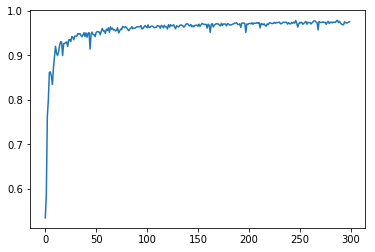

In [113]:
model = NeuralNetworkModel(150)
model.SGD(data.X_train, data.y_train, epochs=300, mini_batch_size=50, eta=0.0025, lmbda=5, x_test=data.X_test, y_test=data.y_test)
text = ""

In [99]:
#隠れ層を増やすほど学習速度は遅くなる。
#学習係数を大きくすると学習が遅くなる。精度の幅がぶれるので安定しない。
model.addText("")